# **Ortam Hazırlığı**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pwd

/content


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/Ayak-Classification-CNN

/content/drive/MyDrive/Colab Notebooks/Ayak-Classification-CNN


# **Veriseti Hazılığı**

In [5]:
import os

data_path = "data/feet_dataset"

# Klasör isimleri
folders = ["train", "test", "val"]

for folder in folders:
    folder_path = os.path.join(data_path, folder)

    # Erkek ve kadın klasörlerini içeren klasör listesi
    gender_folders = ["Erkek", "Kadin"]

    for gender_folder in gender_folders:
        gender_folder_path = os.path.join(folder_path, gender_folder)

        # Klasördeki dosya sayısını öğrenme
        num_files = len(os.listdir(gender_folder_path))

        print(f"{folder} klasörü içinde {gender_folder} klasöründe toplam {num_files} fotoğraf bulunmaktadır.")

train klasörü içinde Erkek klasöründe toplam 1817 fotoğraf bulunmaktadır.
train klasörü içinde Kadin klasöründe toplam 1853 fotoğraf bulunmaktadır.
test klasörü içinde Erkek klasöründe toplam 228 fotoğraf bulunmaktadır.
test klasörü içinde Kadin klasöründe toplam 233 fotoğraf bulunmaktadır.
val klasörü içinde Erkek klasöründe toplam 227 fotoğraf bulunmaktadır.
val klasörü içinde Kadin klasöründe toplam 231 fotoğraf bulunmaktadır.


# **Modelleme**

In [28]:
import tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
# VGG16 önceden eğitilmiş bir CNN modelidir.
conv_base = tensorflow.keras.applications.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3)
                  )


In [30]:
# Erişim katmanlarını gösteriyor
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
# Eğitilecek ve dondurulacak katmanları belirleme.
# 'block5_conv1' katmanına kadar dondurulacak.
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


In [11]:
# Boş bir model oluşturma.
model = tensorflow.keras.models.Sequential()

In [12]:
# VGG16'yı evrişim katmanı olarak eklenmesi.
model.add(conv_base)

In [13]:
# Katmanları matrislerden vektörlere dönüştürme.
model.add(tensorflow.keras.layers.Flatten())

In [46]:
# Özel sinir ağı katmanı eklenmesi.
model.add(tensorflow.keras.layers.Dense(256, activation='relu'))
model.add(tensorflow.keras.layers.Dense(2, activation='softmax'))

In [51]:
# Modelin derlenmesi (compile).
model.compile(loss='categorical_crossentropy',  # Categorical crossentropy kullanılır
              optimizer=tensorflow.keras.optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])



In [16]:
# Oluşturulan modeli gösterme.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21137986 (80.64 MB)
Trainable params: 13502722 (51.51 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [17]:
# Verilerin bulunduğu dizinler belirlenir.
train_dir = 'data/feet_dataset/train'
validation_dir = 'data/feet_dataset/val'
test_dir = 'data/feet_dataset/test'

In [43]:
train_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255, # piksel değerleri 0-255'den 0-1 arasına getiriliyor.
      rotation_range=40, # istenilen artırma işlemleri yapılabilir.
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
      )

In [50]:
# Eğitim verileri oluşturma
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, "train"),
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
    classes=class_names
)

# Validasyon verileri oluşturma
validation_generator = val_datagen.flow_from_directory(
    os.path.join(data_path, "val"),
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
    classes=class_names
)

Found 3670 images belonging to 2 classes.
Found 458 images belonging to 2 classes.


In [54]:
history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=10
)


Epoch 1/10
50/50 [==============================] - 31s 627ms/step - loss: 0.6936 - acc: 0.4963 - val_loss: 0.6930 - val_acc: 0.5125
Epoch 2/10
50/50 [==============================] - 34s 682ms/step - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6938 - val_acc: 0.4938
Epoch 3/10
50/50 [==============================] - 30s 602ms/step - loss: 0.6937 - acc: 0.4913 - val_loss: 0.6932 - val_acc: 0.4906
Epoch 4/10
50/50 [==============================] - 32s 634ms/step - loss: 0.6933 - acc: 0.4969 - val_loss: 0.6930 - val_acc: 0.5094
Epoch 5/10
50/50 [==============================] - 32s 634ms/step - loss: 0.6933 - acc: 0.5119 - val_loss: 0.6938 - val_acc: 0.4938
Epoch 6/10
50/50 [==============================] - 31s 622ms/step - loss: 0.6936 - acc: 0.4844 - val_loss: 0.6933 - val_acc: 0.4688
Epoch 7/10
50/50 [==============================] - 31s 615ms/step - loss: 0.6931 - acc: 0.5044 - val_loss: 0.6931 - val_acc: 0.5063
Epoch 8/10
50/50 [==============================] - 32s 634ms/step - 

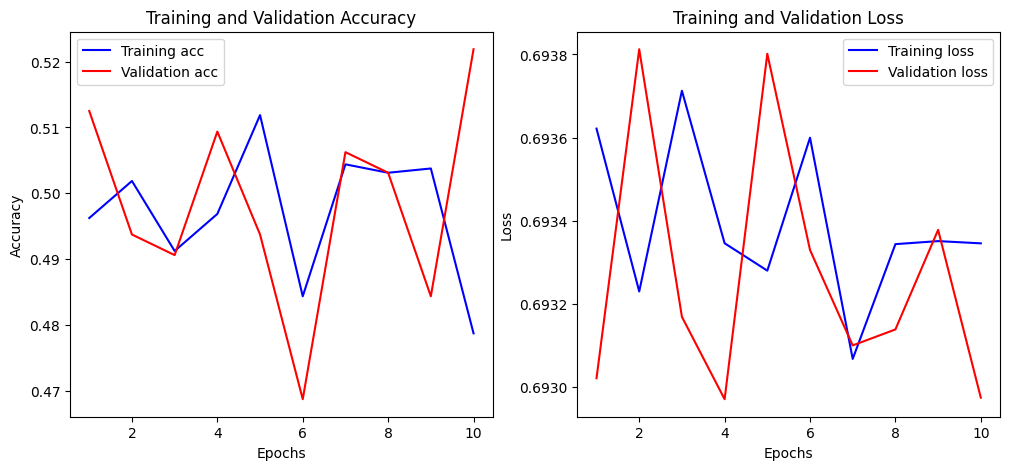

In [55]:
import matplotlib.pyplot as plt

# Eğitim sürecinin sonuçlarını alın
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

# Eğitim ve validasyon doğrulukları
epochs = range(1, len(train_acc) + 1)

# Eğitim ve validasyon doğruluklarının grafiğini oluşturun
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Eğitim ve validasyon kayıplarının grafiğini oluşturun
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
